In [1]:
!pip install datasets==3.0.0

In [1]:
import pandas as pd
from datasets import load_dataset
import datasets
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from wordcloud import WordCloud
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import unittest
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback

# Download the dataset

In [2]:
data = load_dataset("tyqiangz/multilingual-sentiments", "spanish")

In [3]:
df_train = data["train"].to_pandas()
df_test = data["test"].to_pandas()
df_val = data["validation"].to_pandas()

# Exploratory data analysis

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1839 non-null   object
 1   source  1839 non-null   object
 2   label   1839 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 43.2+ KB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    870 non-null    object
 1   source  870 non-null    object
 2   label   870 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 20.5+ KB


In [6]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    324 non-null    object
 1   source  324 non-null    object
 2   label   324 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 7.7+ KB


In [7]:
df_train.head()

,text,source,label
0,estoy hasta el ojete de que me digáis que teng...,intertass_2017,2
1,@user Por? Tenía pensado verla después de la ...,intertass_2017,1
2,Esto de estar feliz mola,intertass_2017,0
3,Ya no es tan divertido,intertass_2017,2
4,@user te recuerdo que soy una persona que tien...,intertass_2017,1


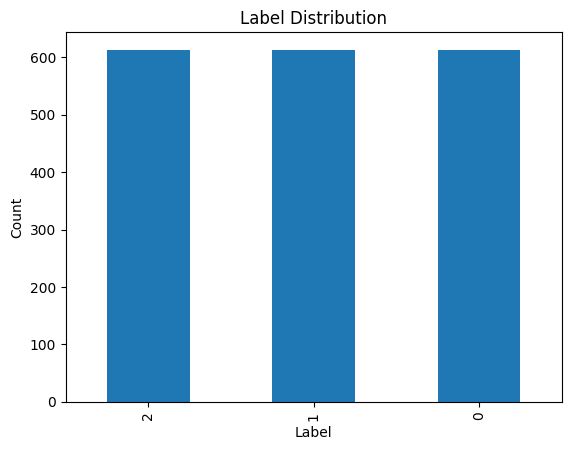

In [8]:
df_train["label"].value_counts().plot(kind="bar")
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

(-0.5, 799.5, 399.5, -0.5)

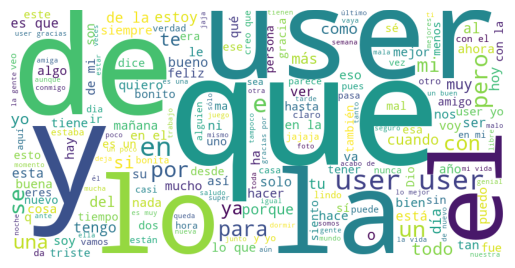

In [9]:
wc = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df_train["text"]))
plt.imshow(wc)
plt.axis('off')

# Data preprocessing

### Cleaning the text

In [10]:
def clean_text(text):
  #Lowercasing
  text = text.lower()
  #Removing @user
  text = re.sub(r'@\w+', '', text)
  #Removing numbers
  text = re.sub(r'\d+', '', text)
  #Removing extra whitespace
  text = re.sub(r'\s+', ' ', text).strip()

  return text

In [11]:
df_train['cleaned'] = df_train['text'].apply(clean_text)

In [12]:
df_test['cleaned'] = df_test['text'].apply(clean_text)

In [13]:
df_val['cleaned'] = df_val['text'].apply(clean_text)

### TF-IDF

In [14]:
!pip install nltk

In [15]:
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")

spanish_stopwords = stopwords.words("spanish")

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    stop_words=spanish_stopwords,
    strip_accents=None,
    token_pattern=r"(?u)\b\w+\b"
    )

X_train_vec = vectorizer.fit_transform(df_train['cleaned']).toarray()
X_test_vec = vectorizer.transform(df_test['cleaned']).toarray()
X_val_vec = vectorizer.transform(df_val['cleaned']).toarray()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(-0.5, 799.5, 399.5, -0.5)

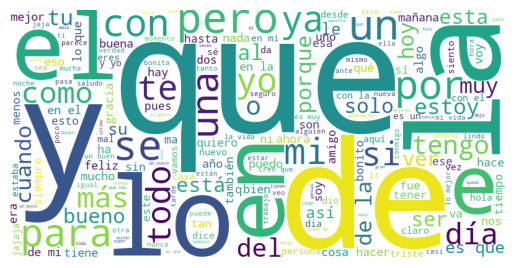

In [16]:
wc = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df_train["cleaned"]))
plt.imshow(wc)
plt.axis('off')

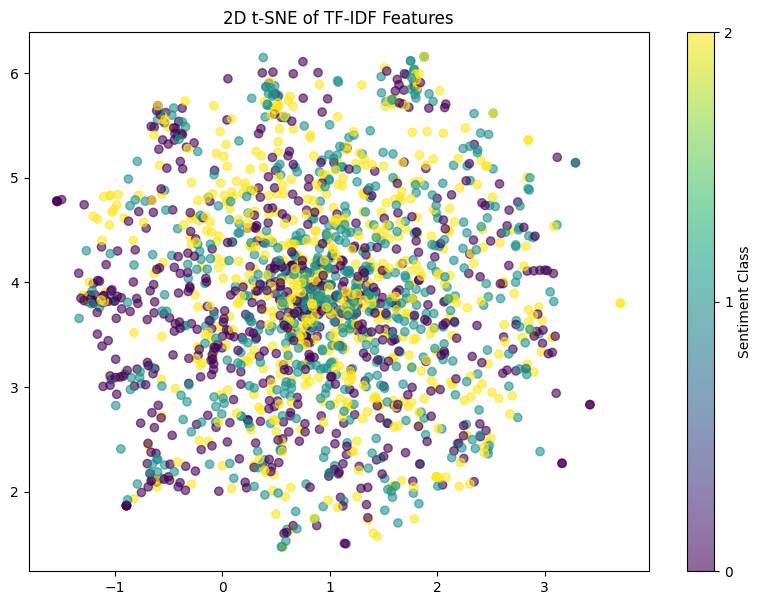

In [17]:
tsne = TSNE(n_components=2, perplexity=40, learning_rate=200)
X_train_2d = tsne.fit_transform(X_train_vec)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    X_train_2d[:, 0],
    X_train_2d[:, 1],
    c = df_train['label'],
    cmap="viridis",
    alpha=0.6
)

plt.colorbar(scatter, ticks=[0,1,2], label="Sentiment Class")
plt.title("2D t-SNE of TF-IDF Features")
plt.show()

### UnitTests

In [18]:
#Prompt: Create a python code for 5 unittest to test my data pipeline
class TestDataPipeline(unittest.TestCase):

    def test_1_clean_text_lowercasing_and_user_removal(self):
        """Tests clean_text for lowercasing and @user removal."""
        text = "@User Hello World! This is a Test."
        expected = "hello world! this is a test."
        self.assertEqual(clean_text(text), expected)

    def test_2_clean_text_numbers_and_whitespace(self):
        """Tests clean_text for number and extra whitespace removal."""
        text = "Text with 123 numbers and   extra   spaces."
        expected = "text with numbers and extra spaces."
        self.assertEqual(clean_text(text), expected)

    def test_3_dataframes_loaded_and_columns(self):
        """Tests if dataframes are loaded and have expected columns."""
        self.assertIsInstance(df_train, pd.DataFrame)
        self.assertFalse(df_train.empty)
        self.assertIn('text', df_train.columns)
        self.assertIn('label', df_train.columns)
        self.assertIn('cleaned', df_train.columns)

        self.assertIsInstance(df_test, pd.DataFrame)
        self.assertFalse(df_test.empty)
        self.assertIn('text', df_test.columns)
        self.assertIn('label', df_test.columns)
        self.assertIn('cleaned', df_test.columns)

        self.assertIsInstance(df_val, pd.DataFrame)
        self.assertFalse(df_val.empty)
        self.assertIn('text', df_val.columns)
        self.assertIn('label', df_val.columns)
        self.assertIn('cleaned', df_val.columns)

    def test_4_tfidf_vectorization_shape(self):
        """Tests the shape of the TF-IDF vectorized output."""
        self.assertIsInstance(X_train_vec, np.ndarray)
        self.assertEqual(X_train_vec.shape[0], len(df_train))
        self.assertEqual(X_train_vec.shape[1], 5000)

    def test_5_tfidf_vectorization_type(self):
        """Tests the data type of the TF-IDF vectorized output."""
        self.assertIsInstance(X_train_vec, np.ndarray)
        self.assertEqual(X_train_vec.dtype, np.float64)

unittest.main(argv=['first-arg-is-ignored'], exit=False)


.....
----------------------------------------------------------------------
Ran 5 tests in 0.003s

OK


# Model training

### Baseline Model — TF-IDF + Neural Network

In [19]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(3, activation='softmax', input_shape=(X_train_vec.shape[1],))
])

# Compile the model
model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# Train the model
model.fit(X_train_vec, df_train['label'].values, epochs=20, batch_size=50, validation_data=(X_val_vec, df_val['label'].values))


Epoch 1/20
37/37 [==============================] - 1s 8ms/step - loss: 1.0975 - accuracy: 0.3676 - val_loss: 1.0935 - val_accuracy: 0.4136
Epoch 2/20
37/37 [==============================] - 0s 4ms/step - loss: 1.0832 - accuracy: 0.6270 - val_loss: 1.0891 - val_accuracy: 0.5154
Epoch 3/20
37/37 [==============================] - 0s 4ms/step - loss: 1.0692 - accuracy: 0.7803 - val_loss: 1.0848 - val_accuracy: 0.5401
Epoch 4/20
37/37 [==============================] - 0s 4ms/step - loss: 1.0551 - accuracy: 0.8630 - val_loss: 1.0809 - val_accuracy: 0.5463
Epoch 5/20
37/37 [==============================] - 0s 4ms/step - loss: 1.0413 - accuracy: 0.8842 - val_loss: 1.0769 - val_accuracy: 0.5370
Epoch 6/20
37/37 [==============================] - 0s 4ms/step - loss: 1.0275 - accuracy: 0.9032 - val_loss: 1.0726 - val_accuracy: 0.5432
Epoch 7/20
37/37 [==============================] - 0s 4ms/step - loss: 1.0140 - accuracy: 0.9125 - val_loss: 1.0689 - val_accuracy: 0.5401
Epoch 8/20
37/37 [==

### Advanced Model — Multilingual Transformer Fine-Tuning (XLM-RoBERTa)

In [20]:
model_name = "xlm-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

In [22]:
tokenized = data.map(tokenize_function, batched=True)

tokenized = tokenized.remove_columns(["text"])
tokenized = tokenized.rename_column("label", "labels")
tokenized.set_format("torch")

Map:   0%|          | 0/324 [00:00<?, ? examples/s]

In [23]:
from sklearn.metrics import accuracy_score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

In [ ]:
# Training arguments (Transformers v5)
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="./logs",
    report_to="none"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

C:\Users\gt\AppData\Local\Temp\ipykernel_11320\226923363.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


In [ ]:
model.save_pretrained("bert-output-es")

In [ ]:
save_path = "models/spanish"

trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)


### Visualization

In [ ]:
logs = trainer.state.log_history

epochs = []
train_loss = []
val_loss = []
val_acc = []

for log in logs:
    if "epoch" in log:
        epoch = log["epoch"]
        if epoch not in epochs:
            epochs.append(epoch)
    if "loss" in log:
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        val_loss.append(log["eval_loss"])
    if "eval_accuracy" in log:
        val_acc.append(log["eval_accuracy"])

#Loss
plt.figure(figsize=(10,4))
plt.plot(range(1, int(training_args.num_train_epochs)+1), train_loss, label="Training Loss", marker='o')
plt.plot(range(1, int(training_args.num_train_epochs)+1), val_loss, label="Validation Loss", marker='o')
plt.title("Training and Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

#Accuracy
if val_acc:
    plt.figure(figsize=(10,4))
    plt.plot(range(1, int(training_args.num_train_epochs)+1), val_acc, label="Validation Accuracy", marker='o', color='green')
    plt.title("Validation Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)  
    plt.grid(True)
    plt.show()

### Evaluation on test data

In [28]:
test_dataset = tokenized["test"]

test_metrics = trainer.evaluate(test_dataset)
print(test_metrics)

{'eval_loss': 0.8055751919746399, 'eval_accuracy': 0.6574712643678161, 'eval_runtime': 129.7307, 'eval_samples_per_second': 6.706, 'eval_steps_per_second': 0.424, 'epoch': 3.0}


### Confusion matrix

In [30]:
pred_output = trainer.predict(tokenized["test"])
y_pred = pred_output.predictions.argmax(axis=1)
y_true = tokenized["test"]["labels"]

<Figure size 600x600 with 0 Axes>

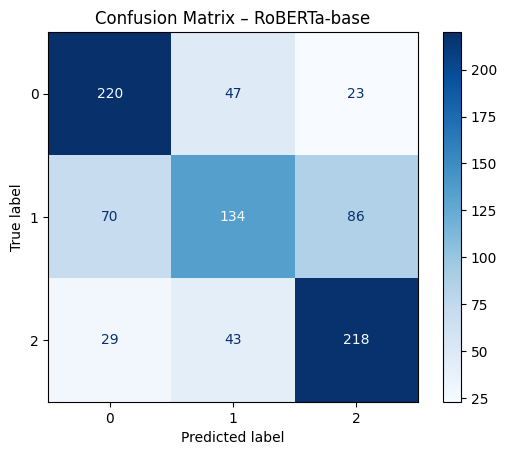

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – RoBERTa-base")
plt.show()